In [1]:
from collections import Counter

import pandas as pd
import seaborn as sns
import scipy.stats as st
from nltk import word_tokenize
import numpy as np
import re
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from tqdm.auto import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from stimulus_gen import StimulusGenerator

In [4]:
cluster = LocalCluster(n_workers=8)
client = Client(cluster)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43081 instead
  warnings.warn(


In [5]:
words = pd.read_csv("adopted_df_blocks_withBalancedUnion.csv").set_index("word_us")

In [6]:
candidate_sentences = pd.read_csv("candidate_sentences-gpt2-annotated.csv", index_col=0)
# Drop manually excluded
candidate_sentences = candidate_sentences[candidate_sentences["JG exclude"].isna()]
candidate_sentences["sentence_length"] = candidate_sentences.sentence.apply(lambda x: len([x for x in word_tokenize(x) if not re.match(r'\W+', x)]))

In [7]:
# only retain words+sentences which have >= 1 sentence for high and low labels
print(candidate_sentences.groupby("target_word").ngroups, "total words")
sentences_per_word = candidate_sentences.groupby("target_word") \
      .label.value_counts().unstack().fillna(0).astype(int)
drop_words = sentences_per_word[(sentences_per_word == 0).any(axis=1)]
drop_words = pd.merge(drop_words, words[["COND", "ortho_n_dens_s", "phono_n_dens_s"]],
                      left_index=True, right_index=True, how="left") \
      .sort_values("COND")
print(f"{len(drop_words)} words missing sentences in one or more conditions:\n",
      drop_words, drop_words.COND.value_counts())

candidate_sentences = candidate_sentences[~candidate_sentences.target_word.isin(drop_words.index)]
print(candidate_sentences.groupby("target_word").ngroups, "words remaining")

129 total words
4 words missing sentences in one or more conditions:
              high  low  COND  ortho_n_dens_s  phono_n_dens_s
target_word                                                 
spit            5    0  O+P+               6               9
vice            6    0  O+P+               8               9
loft            6    0  O+P-               5               4
spark           4    0  O+P-               4               2 COND
O+P+    2
O+P-    2
Name: count, dtype: int64
125 words remaining


In [8]:
# Retain only those covered by the sentences
print(len(words))
words = words.loc[candidate_sentences["target_word"].unique()]
print(len(words))
words

132
125


,word_length,ortho_n_dens_s,ortho_n_freq_s_m,ortho_n_freq_s_sd,ortho_upoint,old20_m,old20_sd,sum_bigram,n_phon,n_syll,...,snd_arc,aff_val_m,aff_val_sd,aff_arou_m,aff_arou_sd,aff_dom_m,aff_dom_sd,Unnamed: 30,COND,block
word_us,,,,,,,,,,,,,,,,,,,,,
angle,5,1,2.612784,NaN,6,1.65,0.489360,0.022517,5,2,...,0.611150,4.55,1.28,3.22,2.24,5.27,1.83,NaN,O+P-,4
area,4,3,1.414313,0.874882,4,1.75,0.444262,0.035175,4,3,...,0.677775,5.56,1.29,2.19,1.60,5.06,1.76,NaN,O-P-,1
baby,4,1,3.258877,NaN,5,1.90,0.307794,0.015180,4,2,...,0.647788,6.67,2.36,4.97,2.65,4.94,2.87,NaN,O-P-,4
bait,4,4,2.487701,1.650007,4,1.70,0.470162,0.026305,3,1,...,0.514355,4.00,1.83,3.50,2.02,5.95,2.32,NaN,O-P+,2
beach,5,7,2.384041,0.929191,6,1.50,0.512989,0.047662,3,1,...,0.658304,7.21,1.51,5.10,2.23,5.70,2.33,NaN,O+P+,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wish,4,7,2.958385,1.461394,5,1.60,0.502625,0.029318,3,1,...,0.637178,7.14,1.77,3.38,2.33,6.50,2.33,NaN,O+P+,4
wood,4,7,3.371046,1.074693,5,1.50,0.512989,0.019520,3,1,...,0.667203,5.82,1.47,3.50,1.70,6.37,2.71,NaN,O+P+,3
wrong,5,2,1.501730,0.420884,6,1.90,0.307794,0.031888,3,1,...,0.636805,3.24,1.48,5.29,2.19,3.39,1.97,NaN,O-P+,1


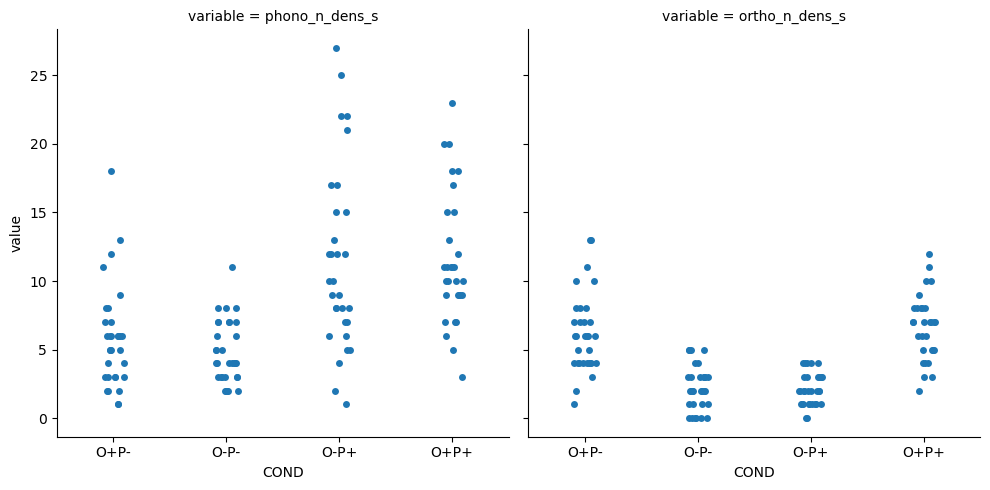

In [9]:
sns.catplot(data=words[["COND", "phono_n_dens_s", "ortho_n_dens_s"]].melt(id_vars=["COND"]), x="COND", y="value", col="variable")

In [10]:
# # drop low-PND outliers in P+ conditions
# words = words.loc[~words.index.isin(words[(words.COND == "O-P+") & (words.phono_n_dens_s < 5)].index)]
to_drop = words[((words.COND == "O-P+") & (words.phono_n_dens_s <= 6)) |
                ((words.COND == "O+P+") & (words.phono_n_dens_s <= 6))].index
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]

Index(['camp', 'cause', 'drip', 'duty', 'earth', 'feud', 'floor', 'frame',
       'plane', 'stray'],
      dtype='object', name='word_us')


In [11]:
# drop low-OND outliers in O+ condition
to_drop = words[(words.COND == "O+P-") & (words.ortho_n_dens_s <= 2)].index
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]

Index(['angle', 'dream'], dtype='object', name='word_us')


In [12]:
# drop high-PND outliers in P- conditions
to_drop = words[((words.COND == "O+P-") & (words.phono_n_dens_s > 10)) |
                ((words.COND == "O-P-") & (words.phono_n_dens_s >= 8))].index
# keep "fence" and "style" because these are high-bigram-freq and we need these to balance the dataset
to_drop = to_drop.difference(["fence", "style"])
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]
print(len(words))

Index(['bunk', 'chief', 'chin', 'joke', 'sage', 'staff'], dtype='object', name='word_us')
107


In [13]:
# drop high-OND outliers in O- conditions
to_drop = words[(words.COND == "O-P-") & (words.ortho_n_dens_s > 4)].index
print(to_drop)
words = words.loc[~words.index.isin(to_drop)]
print(len(words))

Index(['bench', 'daily', 'gift', 'shirt'], dtype='object', name='word_us')
103


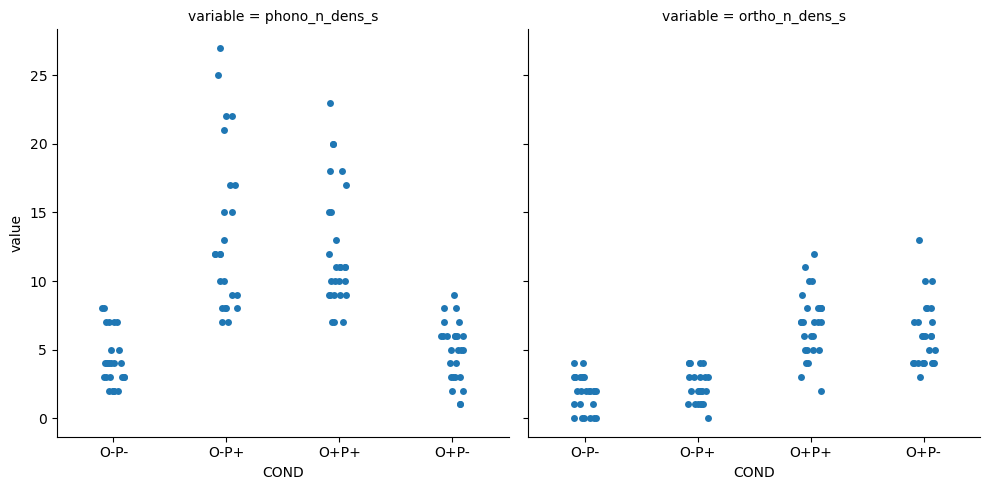

In [14]:
sns.catplot(data=words[["COND", "phono_n_dens_s", "ortho_n_dens_s"]].melt(id_vars=["COND"]), x="COND", y="value", col="variable")

## Rejection sampling method

In [15]:
merged = pd.merge(candidate_sentences, words, left_on="target_word", right_on="word_us")
merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())

/tmp/ipykernel_1646781/1251679934.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())


COND
O+P+    27
O+P-    26
O-P+    24
O-P-    26
dtype: int64

In [16]:
gen = StimulusGenerator(words, candidate_sentences)

In [17]:
s_words, s_sentences, s_melted = gen.get_sample()
s_sentences.groupby("block").target_word.value_counts().max()

2

In [18]:
@delayed
def sample_and_evaluate():
    s_words, s_sentences, s_melted = gen.get_sample()
    obj, sentinel = gen.objective(s_sentences, s_melted)
    return obj, sentinel, (s_words, s_sentences, s_melted)

In [19]:
# Create a list of delayed evaluation tasks
tasks = [sample_and_evaluate() for i in range(100000)]

# Compute all tasks in parallel
with ProgressBar():
    results = compute(*tasks, scheduler="processes")

# Extract the best sample and objective value
failure_causes = Counter()
best_objective = float("-inf")
best_sample = None

for i, (obj, sentinel, sample) in enumerate(results):
    failure_causes[sentinel] += 1
    if obj > best_objective:
        print(i, obj)
        best_objective = obj
        best_sample = sample

/home/jgauthier/u/transformers/lib/python3.10/site-packages/dask/base.py:1487: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


[                                        ] | 0% Completed | 15.18 sms

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 0% Completed | 18.65 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 0% Completed | 35.07 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 1% Completed | 40.14 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 1% Completed | 52.61 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 1% Completed | 53.63 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[                                        ] | 2% Completed | 59.52 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 2% Completed | 73.28 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 3% Completed | 83.24 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 3% Completed | 99.45 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#                                       ] | 4% Completed | 123.46 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 5% Completed | 130.28 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##                                      ] | 5% Completed | 136.22 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 5% Completed | 139.73 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 6% Completed | 151.69 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 6% Completed | 168.77 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 7% Completed | 173.26 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##                                      ] | 7% Completed | 179.95 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 7% Completed | 185.03 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 7% Completed | 189.52 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 8% Completed | 198.17 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###                                     ] | 8% Completed | 210.11 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###                                     ] | 8% Completed | 212.86 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 9% Completed | 218.53 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###                                     ] | 9% Completed | 226.72 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###                                     ] | 9% Completed | 234.17 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 11% Completed | 270.60 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 11% Completed | 280.34 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 11% Completed | 283.62 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####                                    ] | 12% Completed | 299.91 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####                                   ] | 13% Completed | 320.07 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####                                   ] | 13% Completed | 329.53 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####                                   ] | 13% Completed | 343.89 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####                                   ] | 14% Completed | 348.99 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####                                   ] | 14% Completed | 363.83 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 15% Completed | 384.62 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 16% Completed | 415.01 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######                                  ] | 17% Completed | 432.74 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#######                                 ] | 17% Completed | 443.22 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 18% Completed | 452.40 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 18% Completed | 469.96 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 19% Completed | 484.77 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#######                                 ] | 19% Completed | 489.24 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########                                ] | 21% Completed | 528.75 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[########                                ] | 21% Completed | 538.59 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########                                ] | 21% Completed | 541.10 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 22% Completed | 552.97 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 23% Completed | 560.24 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 23% Completed | 564.13 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 23% Completed | 566.93 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 23% Completed | 574.73 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########                               ] | 24% Completed | 598.52 s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#########                               ] | 24% Completed | 10m 4s s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##########                              ] | 26% Completed | 10m 40s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########                              ] | 26% Completed | 10m 44s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###########                             ] | 28% Completed | 11m 12s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 28% Completed | 11m 15s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########                             ] | 29% Completed | 11m 34s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############                            ] | 31% Completed | 12m 31s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############                            ] | 32% Completed | 12m 38s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############                            ] | 32% Completed | 12m 39s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############                           ] | 33% Completed | 12m 55s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############                           ] | 33% Completed | 13m 0ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############                           ] | 34% Completed | 13m 23s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############                           ] | 34% Completed | 13m 24s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##############                          ] | 35% Completed | 13m 53s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##############                          ] | 35% Completed | 13m 54s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############                          ] | 36% Completed | 14m 9ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############                          ] | 36% Completed | 14m 12s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############                          ] | 37% Completed | 14m 23s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 37% Completed | 14m 33s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 38% Completed | 14m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 38% Completed | 14m 48s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 39% Completed | 15m 1ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###############                         ] | 39% Completed | 15m 2s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############                         ] | 39% Completed | 15m 24s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 40% Completed | 15m 31s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[################                        ] | 40% Completed | 15m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 40% Completed | 15m 37s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 41% Completed | 15m 46s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 41% Completed | 15m 49s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################                        ] | 42% Completed | 16m 9ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#################                       ] | 42% Completed | 16m 21s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 16m 26s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 16m 32s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 16m 34s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 16m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 16m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################                       ] | 43% Completed | 16m 44s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#################                       ] | 44% Completed | 16m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 45% Completed | 17m 5ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 45% Completed | 17m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 45% Completed | 17m 18s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 45% Completed | 17m 19s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 46% Completed | 17m 30s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################                      ] | 47% Completed | 17m 51s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##################                      ] | 47% Completed | 17m 56s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 47% Completed | 18m 3ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 47% Completed | 18m 6s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 48% Completed | 18m 24s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################                     ] | 49% Completed | 18m 43s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 50% Completed | 18m 54s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 50% Completed | 19m 11s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 51% Completed | 19m 38s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 51% Completed | 19m 39s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 52% Completed | 19m 40s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################                    ] | 52% Completed | 19m 42s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 52% Completed | 19m 48s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################                   ] | 52% Completed | 19m 50s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 53% Completed | 20m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################                   ] | 54% Completed | 20m 32s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################                   ] | 54% Completed | 20m 34s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################                   ] | 54% Completed | 20m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################                   ] | 54% Completed | 20m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 55% Completed | 20m 48s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 55% Completed | 20m 53s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 55% Completed | 20m 54s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 56% Completed | 21m 1ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################                  ] | 56% Completed | 21m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[######################                  ] | 56% Completed | 21m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[######################                  ] | 57% Completed | 21m 26s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#######################                 ] | 58% Completed | 21m 48s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#######################                 ] | 59% Completed | 22m 16s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########################                ] | 60% Completed | 22m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[########################                ] | 61% Completed | 22m 44s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########################                ] | 61% Completed | 22m 50s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########################                ] | 61% Completed | 22m 53s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 62% Completed | 23m 15s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#########################               ] | 62% Completed | 23m 23s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#########################               ] | 64% Completed | 24m 10s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 65% Completed | 24m 20s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 65% Completed | 24m 20s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 65% Completed | 24m 23s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 65% Completed | 24m 31s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 66% Completed | 24m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##########################              ] | 67% Completed | 25m 8ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 67% Completed | 25m 18s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 68% Completed | 25m 26s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 68% Completed | 25m 27s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 68% Completed | 25m 33s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 69% Completed | 25m 46s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 69% Completed | 25m 56s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###########################             ] | 69% Completed | 25m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 70% Completed | 26m 2ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 70% Completed | 26m 13s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 70% Completed | 26m 15s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 71% Completed | 26m 18s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 71% Completed | 26m 19s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 72% Completed | 26m 33s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 72% Completed | 26m 35s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[############################            ] | 72% Completed | 26m 38s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[############################            ] | 72% Completed | 26m 38s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 72% Completed | 26m 44s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 72% Completed | 26m 45s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 73% Completed | 27m 1ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#############################           ] | 74% Completed | 27m 12s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##############################          ] | 75% Completed | 27m 34s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 75% Completed | 27m 42s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 75% Completed | 27m 51s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##############################          ] | 77% Completed | 28m 20s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###############################         ] | 77% Completed | 28m 33s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 78% Completed | 28m 45s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 79% Completed | 28m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 79% Completed | 28m 59s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###############################         ] | 79% Completed | 29m 2ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[###############################         ] | 79% Completed | 29m 5s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 81% Completed | 29m 51s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 81% Completed | 29m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 81% Completed | 29m 58s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[################################        ] | 81% Completed | 30m 4ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#################################       ] | 83% Completed | 30m 41s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################################       ] | 84% Completed | 30m 52s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#################################       ] | 84% Completed | 30m 59s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##################################      ] | 85% Completed | 31m 6ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[##################################      ] | 85% Completed | 31m 9s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 85% Completed | 31m 20s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 86% Completed | 31m 26s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 86% Completed | 31m 30s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 86% Completed | 31m 45s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[##################################      ] | 87% Completed | 31m 52s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################################     ] | 87% Completed | 32m 2ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################################     ] | 88% Completed | 32m 7s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################################     ] | 88% Completed | 32m 7s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[###################################     ] | 88% Completed | 32m 9s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[####################################    ] | 90% Completed | 32m 56s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################    ] | 90% Completed | 33m 0ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################    ] | 91% Completed | 33m 19s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################    ] | 92% Completed | 33m 35s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################################   ] | 92% Completed | 33m 43s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################################   ] | 92% Completed | 33m 45s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 93% Completed | 33m 49s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################################   ] | 93% Completed | 33m 56s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 93% Completed | 33m 58s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 94% Completed | 34m 11s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[#####################################   ] | 94% Completed | 34m 15s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 94% Completed | 34m 17s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[#####################################   ] | 94% Completed | 34m 22s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[######################################  ] | 95% Completed | 34m 33s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[######################################  ] | 96% Completed | 34m 57s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[####################################### ] | 97% Completed | 35m 14s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################### ] | 98% Completed | 35m 36s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################### ] | 99% Completed | 35m 46s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[####################################### ] | 99% Completed | 35m 49s

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[####################################### ] | 99% Completed | 36m 0ss

/home/jgauthier/u/transformers/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[########################################] | 100% Completed | 36m 1s
1 0.00019405364716687374
15 0.007905172007108757
25 0.00927485847839472
86 0.010785928688861081
206 0.018871214183064797
252 0.01944738058211123
1499 0.02160319550417513
1624 0.024760540603737325
3057 0.026824163871528098
4101 0.027750995573681325
6518 0.03450161013700666
9307 0.053983534437364235
88598 0.06728680112689987


In [20]:
failure_causes.most_common()

[(None, 27187),
 (('null_t', ('ortho_n_dens_s', 'COND', 'O+P+', 'O+P-')), 11567),
 (('null_t', ('ortho_n_dens_s', 'COND', 'O-P+', 'O-P-')), 7555),
 (('block_null_t', ('ortho_n_dens_s', 'COND', 'O+P+', 'O+P-')), 7518),
 (('block_positive_t', ('ortho_n_dens_s', 'COND', 'O+P+', 'O-P+')), 7318),
 (('null_t', ('phono_n_dens_s', 'COND', 'O+P-', 'O-P-')), 6532),
 (('block_positive_t', ('phono_n_dens_s', 'COND', 'O-P+', 'O-P-')), 5732),
 (('block_null_t', ('phono_n_dens_s', 'COND', 'O+P-', 'O-P-')), 5705),
 (('block_positive_t', ('ortho_n_dens_s', 'COND', 'O+P-', 'O-P-')), 5030),
 (('block_positive_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O+P-')), 4993),
 (('block_null_t', ('ortho_n_dens_s', 'COND', 'O-P+', 'O-P-')), 3706),
 (('block_null_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O-P+')), 2254),
 (('null_t', ('phono_n_dens_s', 'COND', 'O+P+', 'O-P+')), 2081),
 (('block_positive_t', ('ortho_n_dens_s', 'COND', 'O-P-', 'O+P+')), 934),
 (('block_positive_t', ('phono_n_dens_s', 'COND', 'O-P-', 'O+P+')

In [22]:
# sample id is a hash of the current timestamp
from time import time
from hashlib import sha1
sample_id = sha1(str(int(time())).encode()).hexdigest()[:8]
print(sample_id)

s_words, s_sentences, s_melted = best_sample
s_words.to_csv(f"{sample_id}-words.csv")
s_sentences.to_csv(f"{sample_id}-sentences.csv")
s_melted.to_csv(f"{sample_id}-melted.csv")

s_stats = gen.get_stats(s_melted).sort_values("p")
s_stats.to_csv(f"{sample_id}-stats.csv")

a0246a17


In [23]:
s_stats

F             p
variable         block_union                          
surprisal        6            163.039494  3.552506e-58
                 5            100.386605  2.447997e-29
                 4             79.423530  9.602287e-27
ortho_n_dens_s   6             32.975498  3.588348e-25
old20_m          6             31.909410  1.268034e-24
...                                  ...           ...
ortho_n_freq_s_m 2                   NaN           NaN
                 3                   NaN           NaN
                 4                   NaN           NaN
                 5                   NaN           NaN
                 6                   NaN           NaN

[140 rows x 2 columns]

## Marginal plots

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Target manipulations')

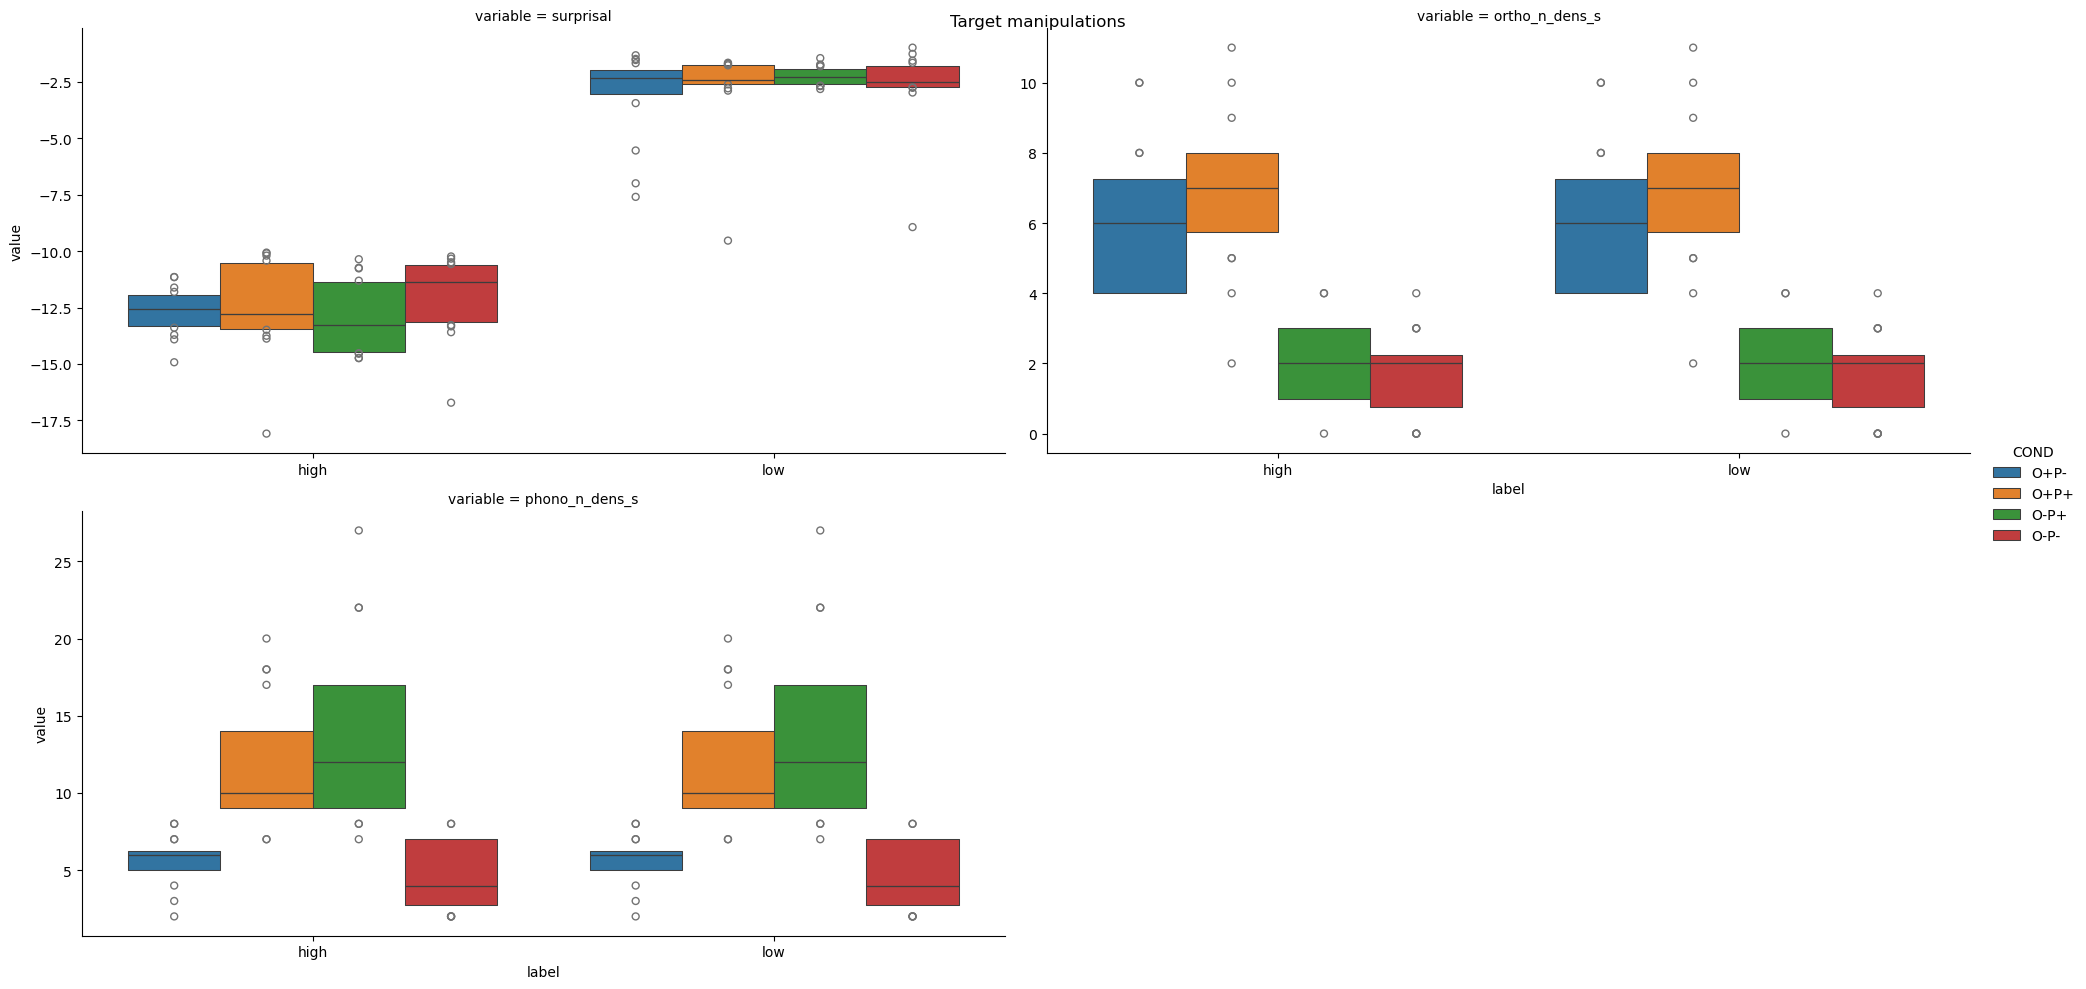

In [24]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(gen.max_variables)],
                x="label", hue="COND", y="value", col="variable", col_wrap=2,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Target manipulations")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Aim to match between conditions')

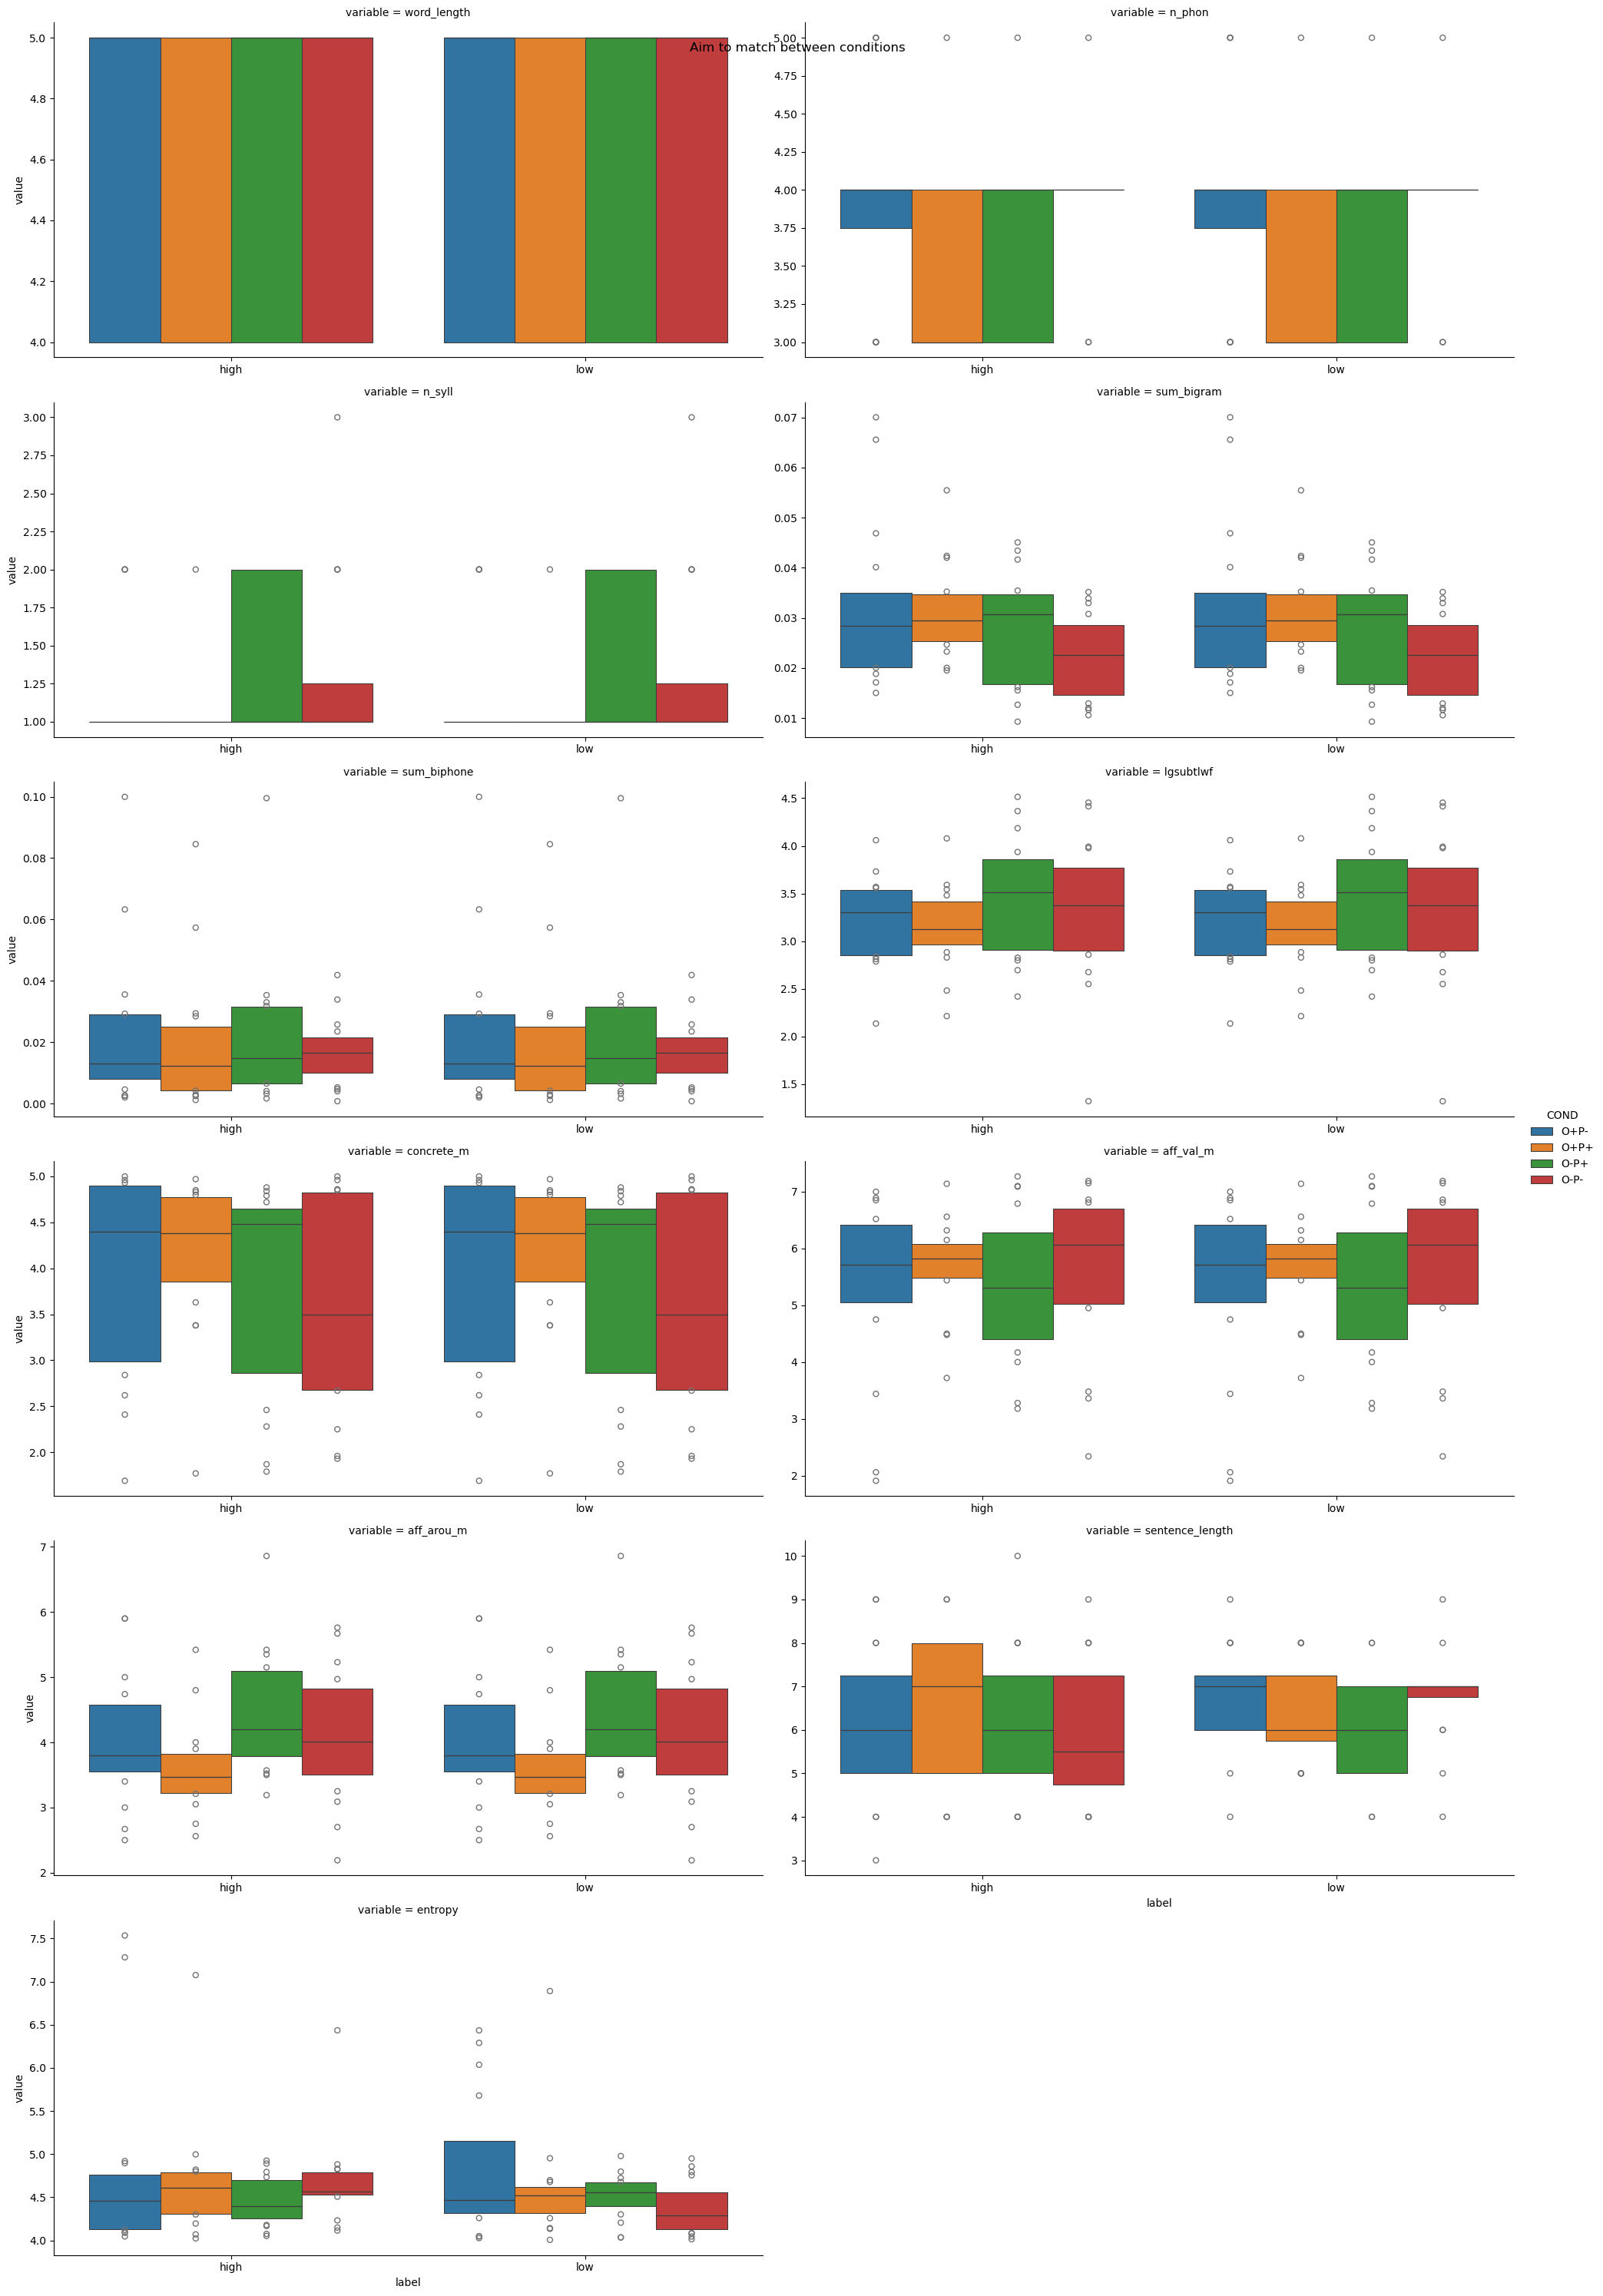

In [25]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(gen.min_variables)],
                x="label", hue="COND", y="value", col="variable", col_wrap=2,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Aim to match between conditions")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Other stuff')

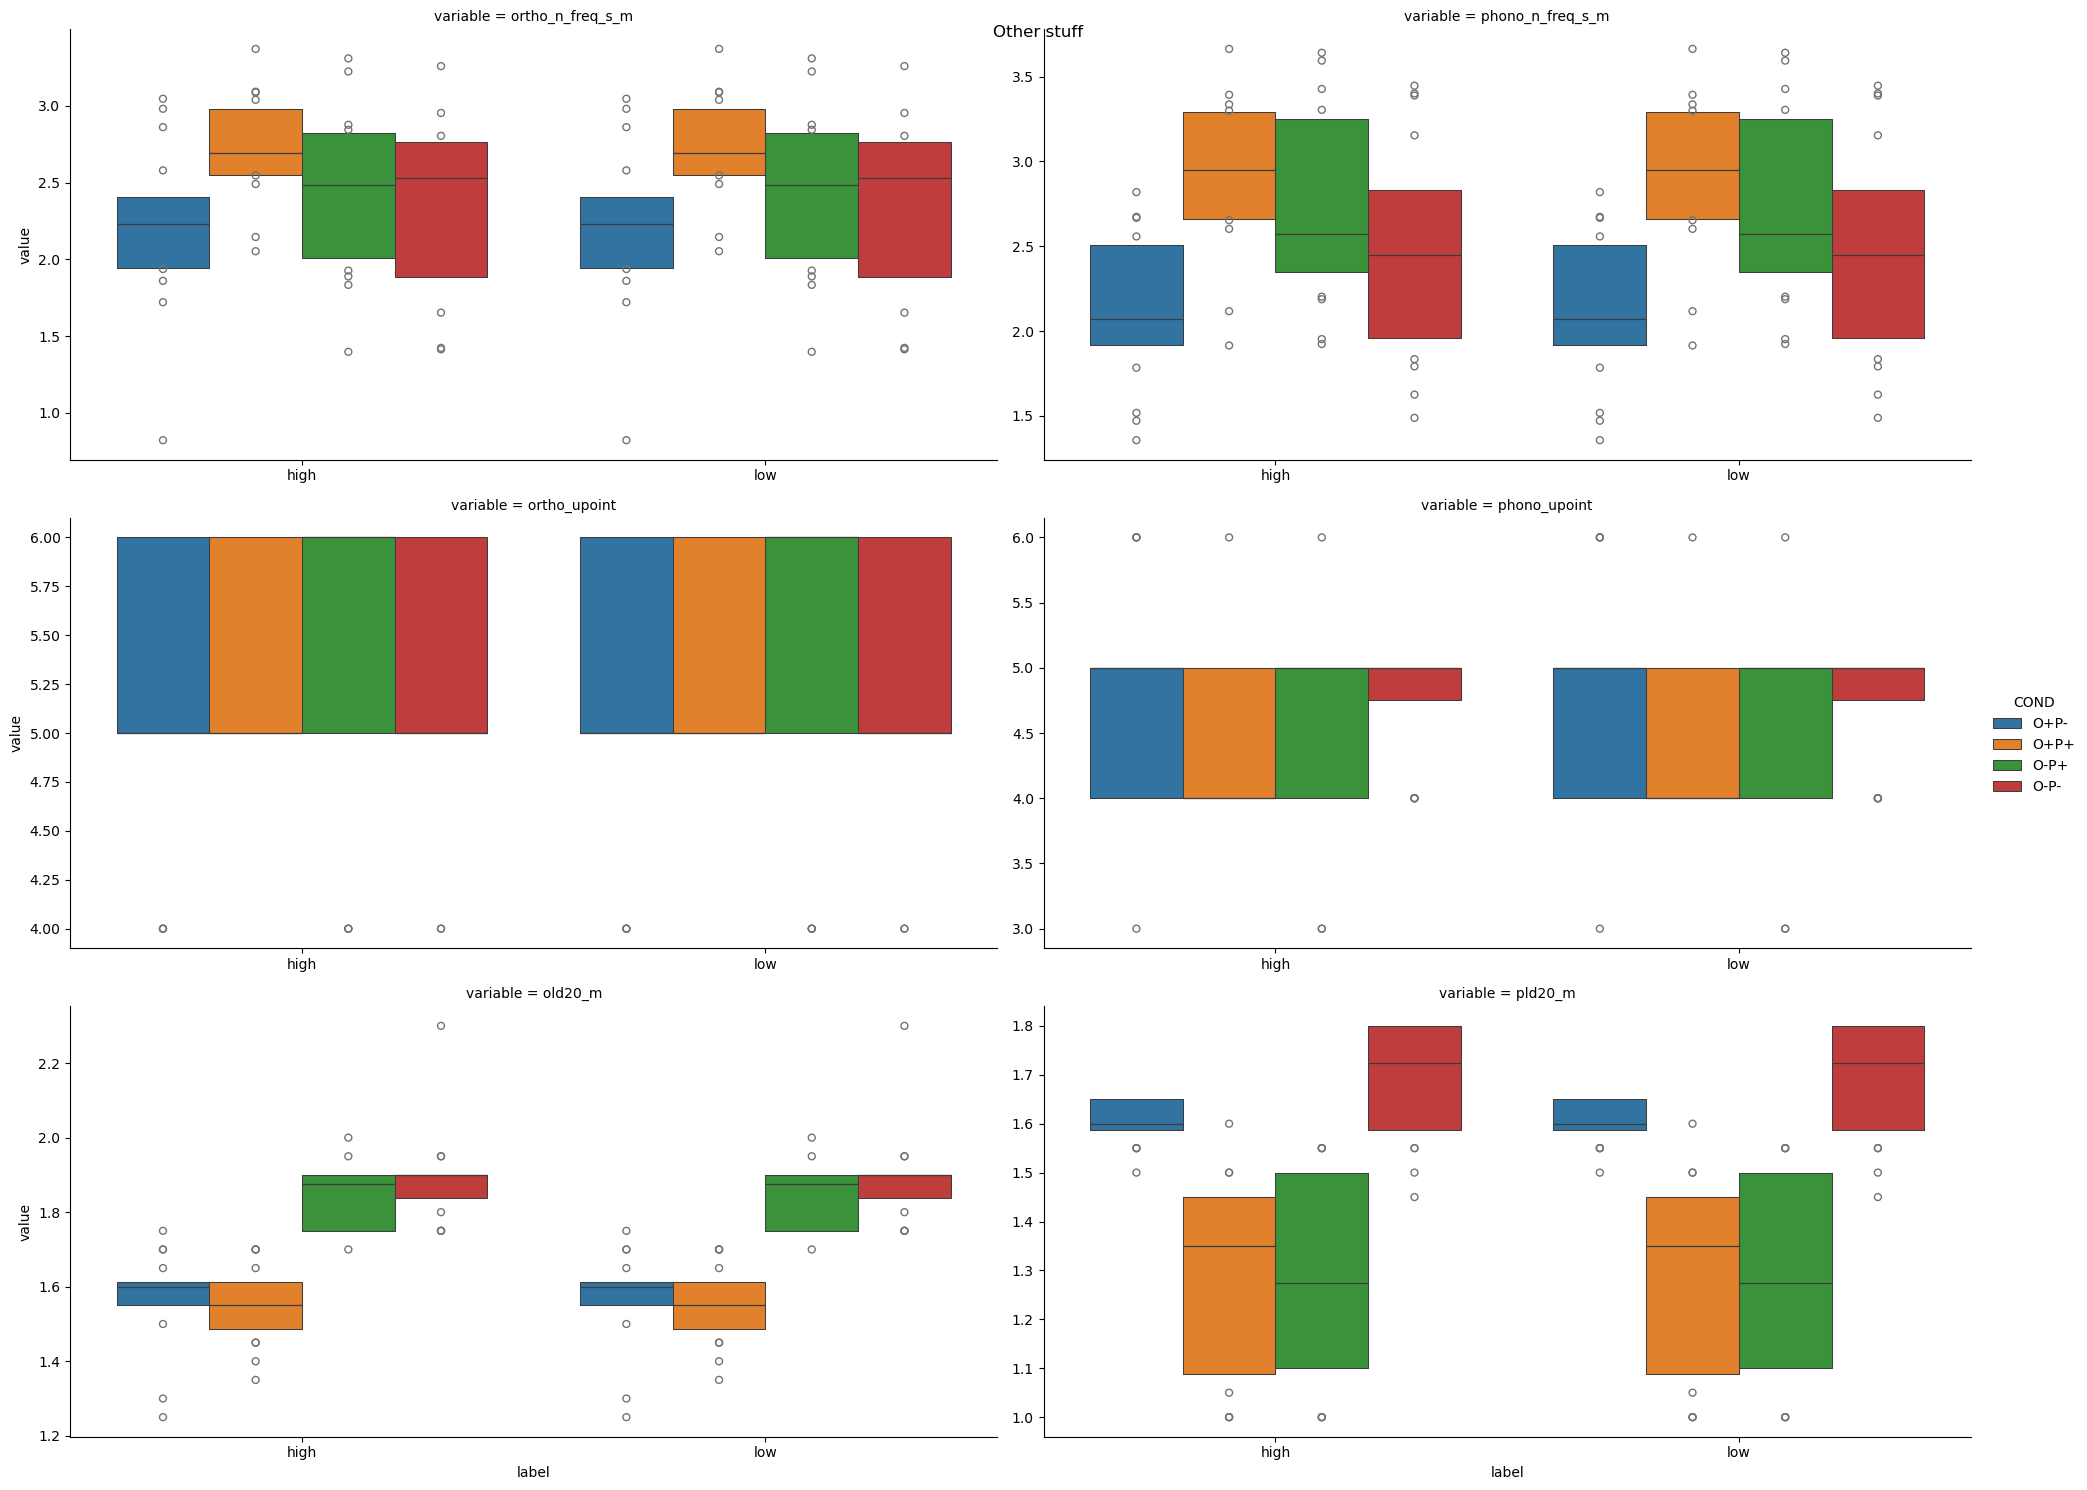

In [26]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(gen.monitor_variables)],
                x="label", hue="COND", y="value", col="variable", col_wrap=2,
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Other stuff")

## Plots by block

Text(0.5, 0.98, 'Target manipulations')

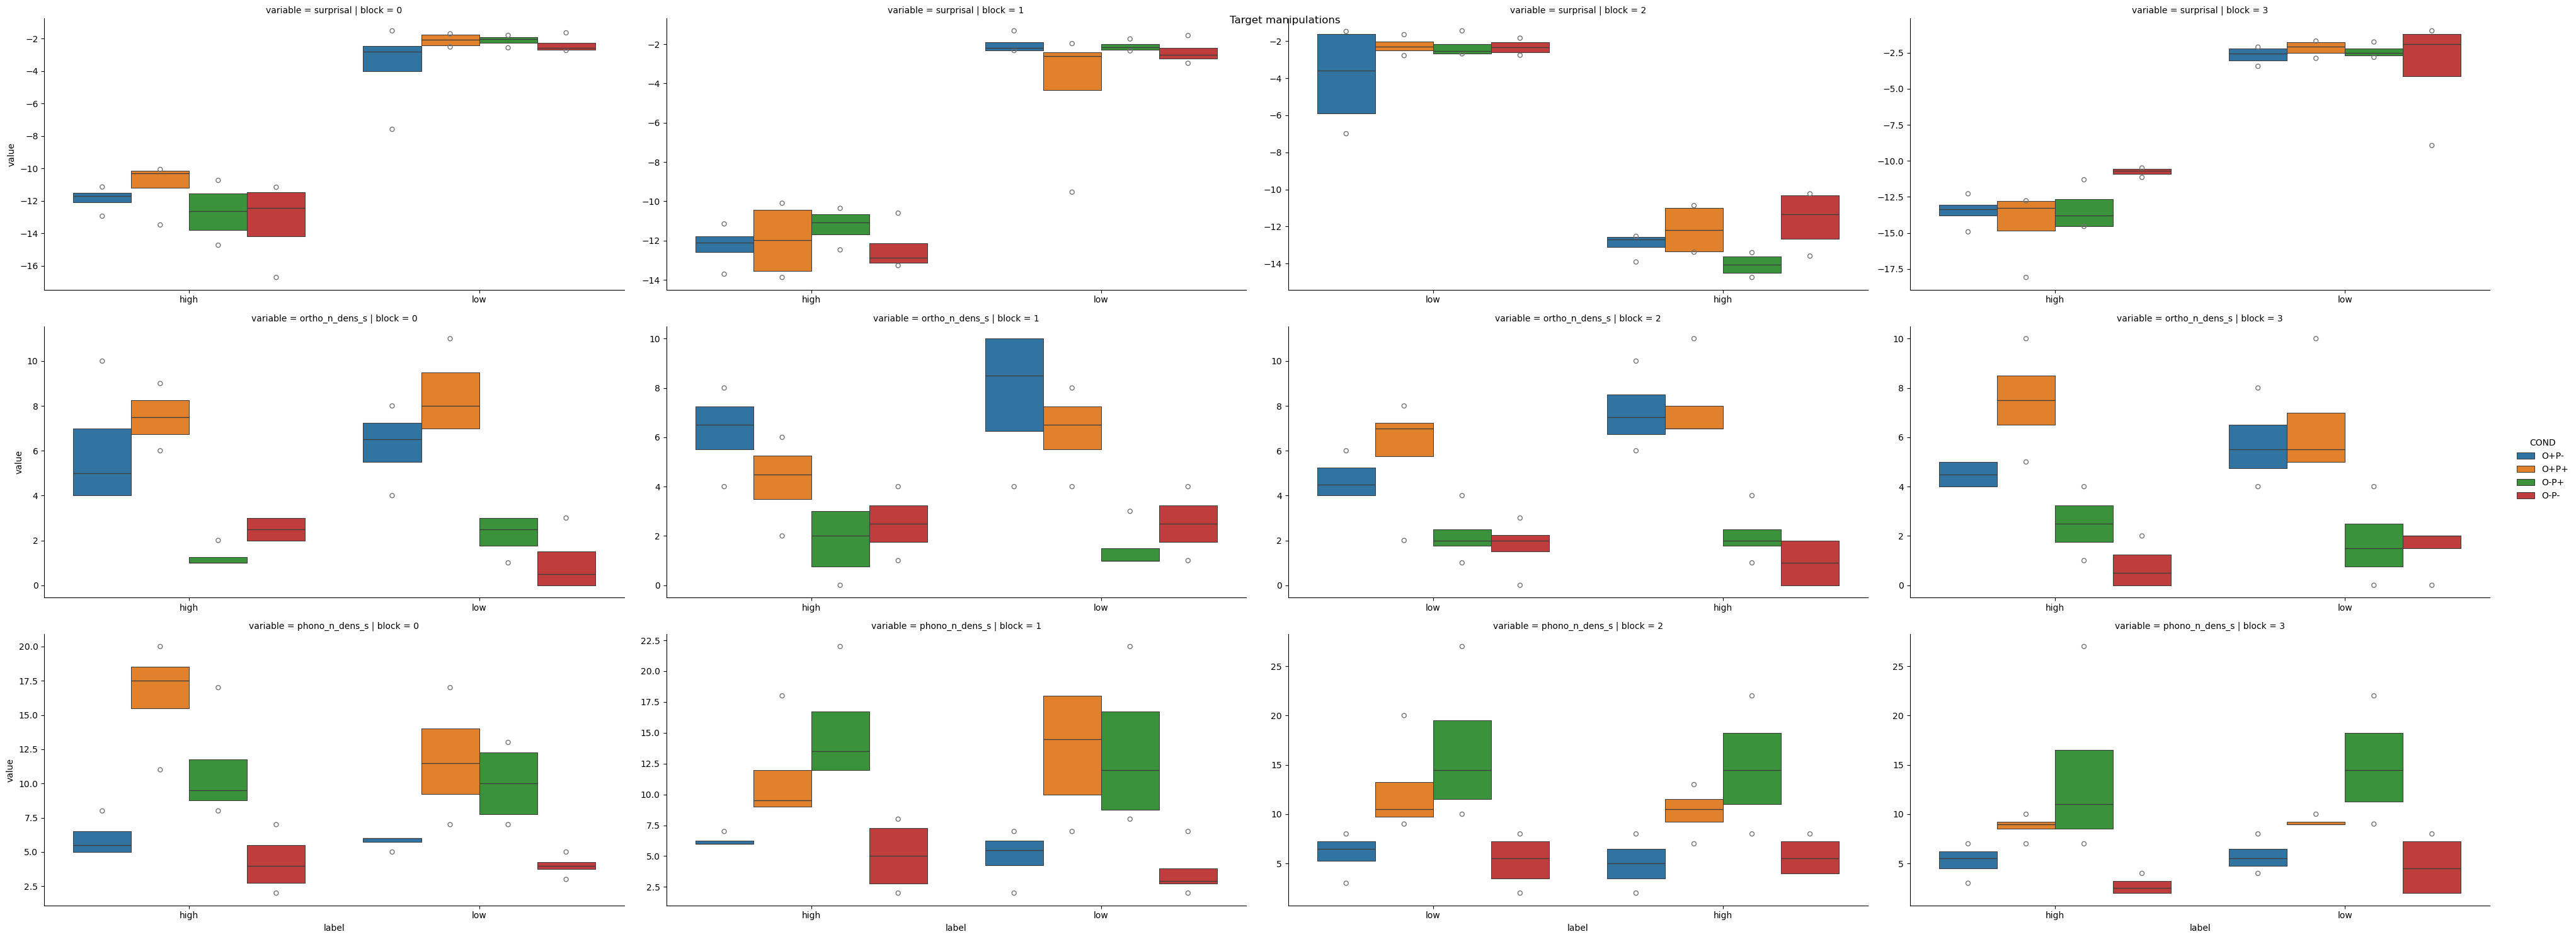

In [28]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(gen.max_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Target manipulations")

Text(0.5, 0.98, 'Aim to match between conditions')

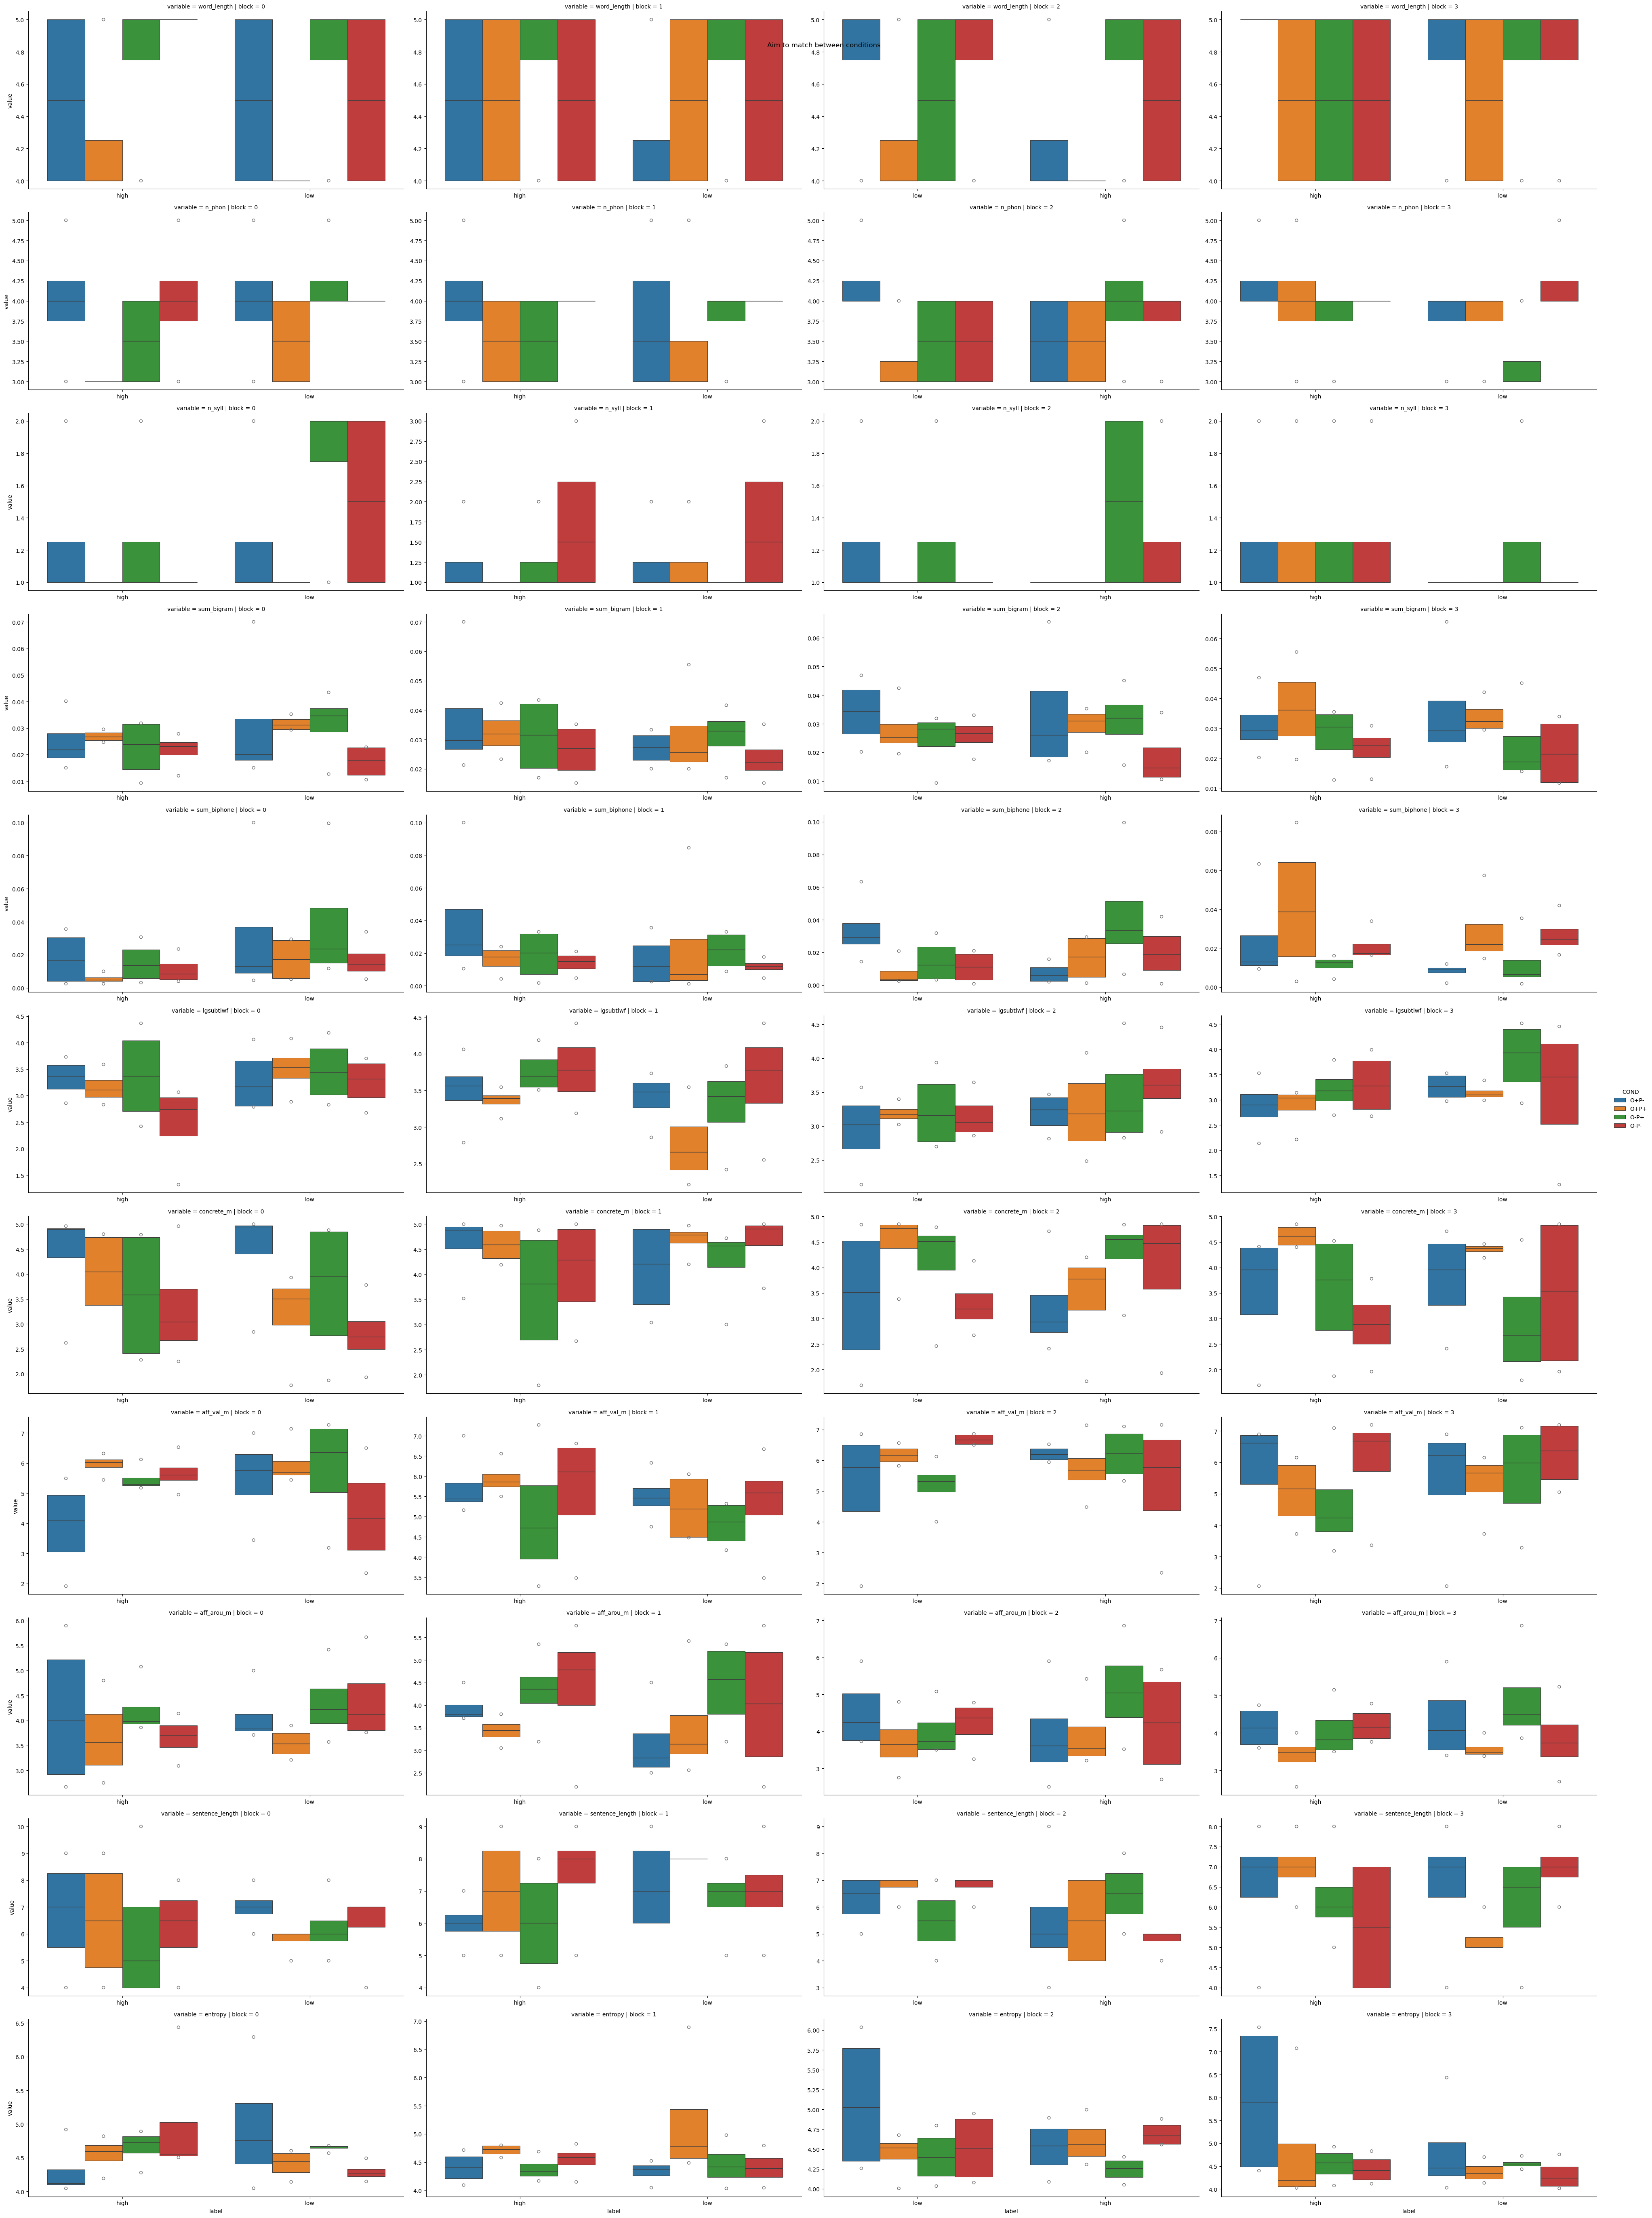

In [29]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(gen.min_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Aim to match between conditions")

Text(0.5, 0.98, 'Other stuff')

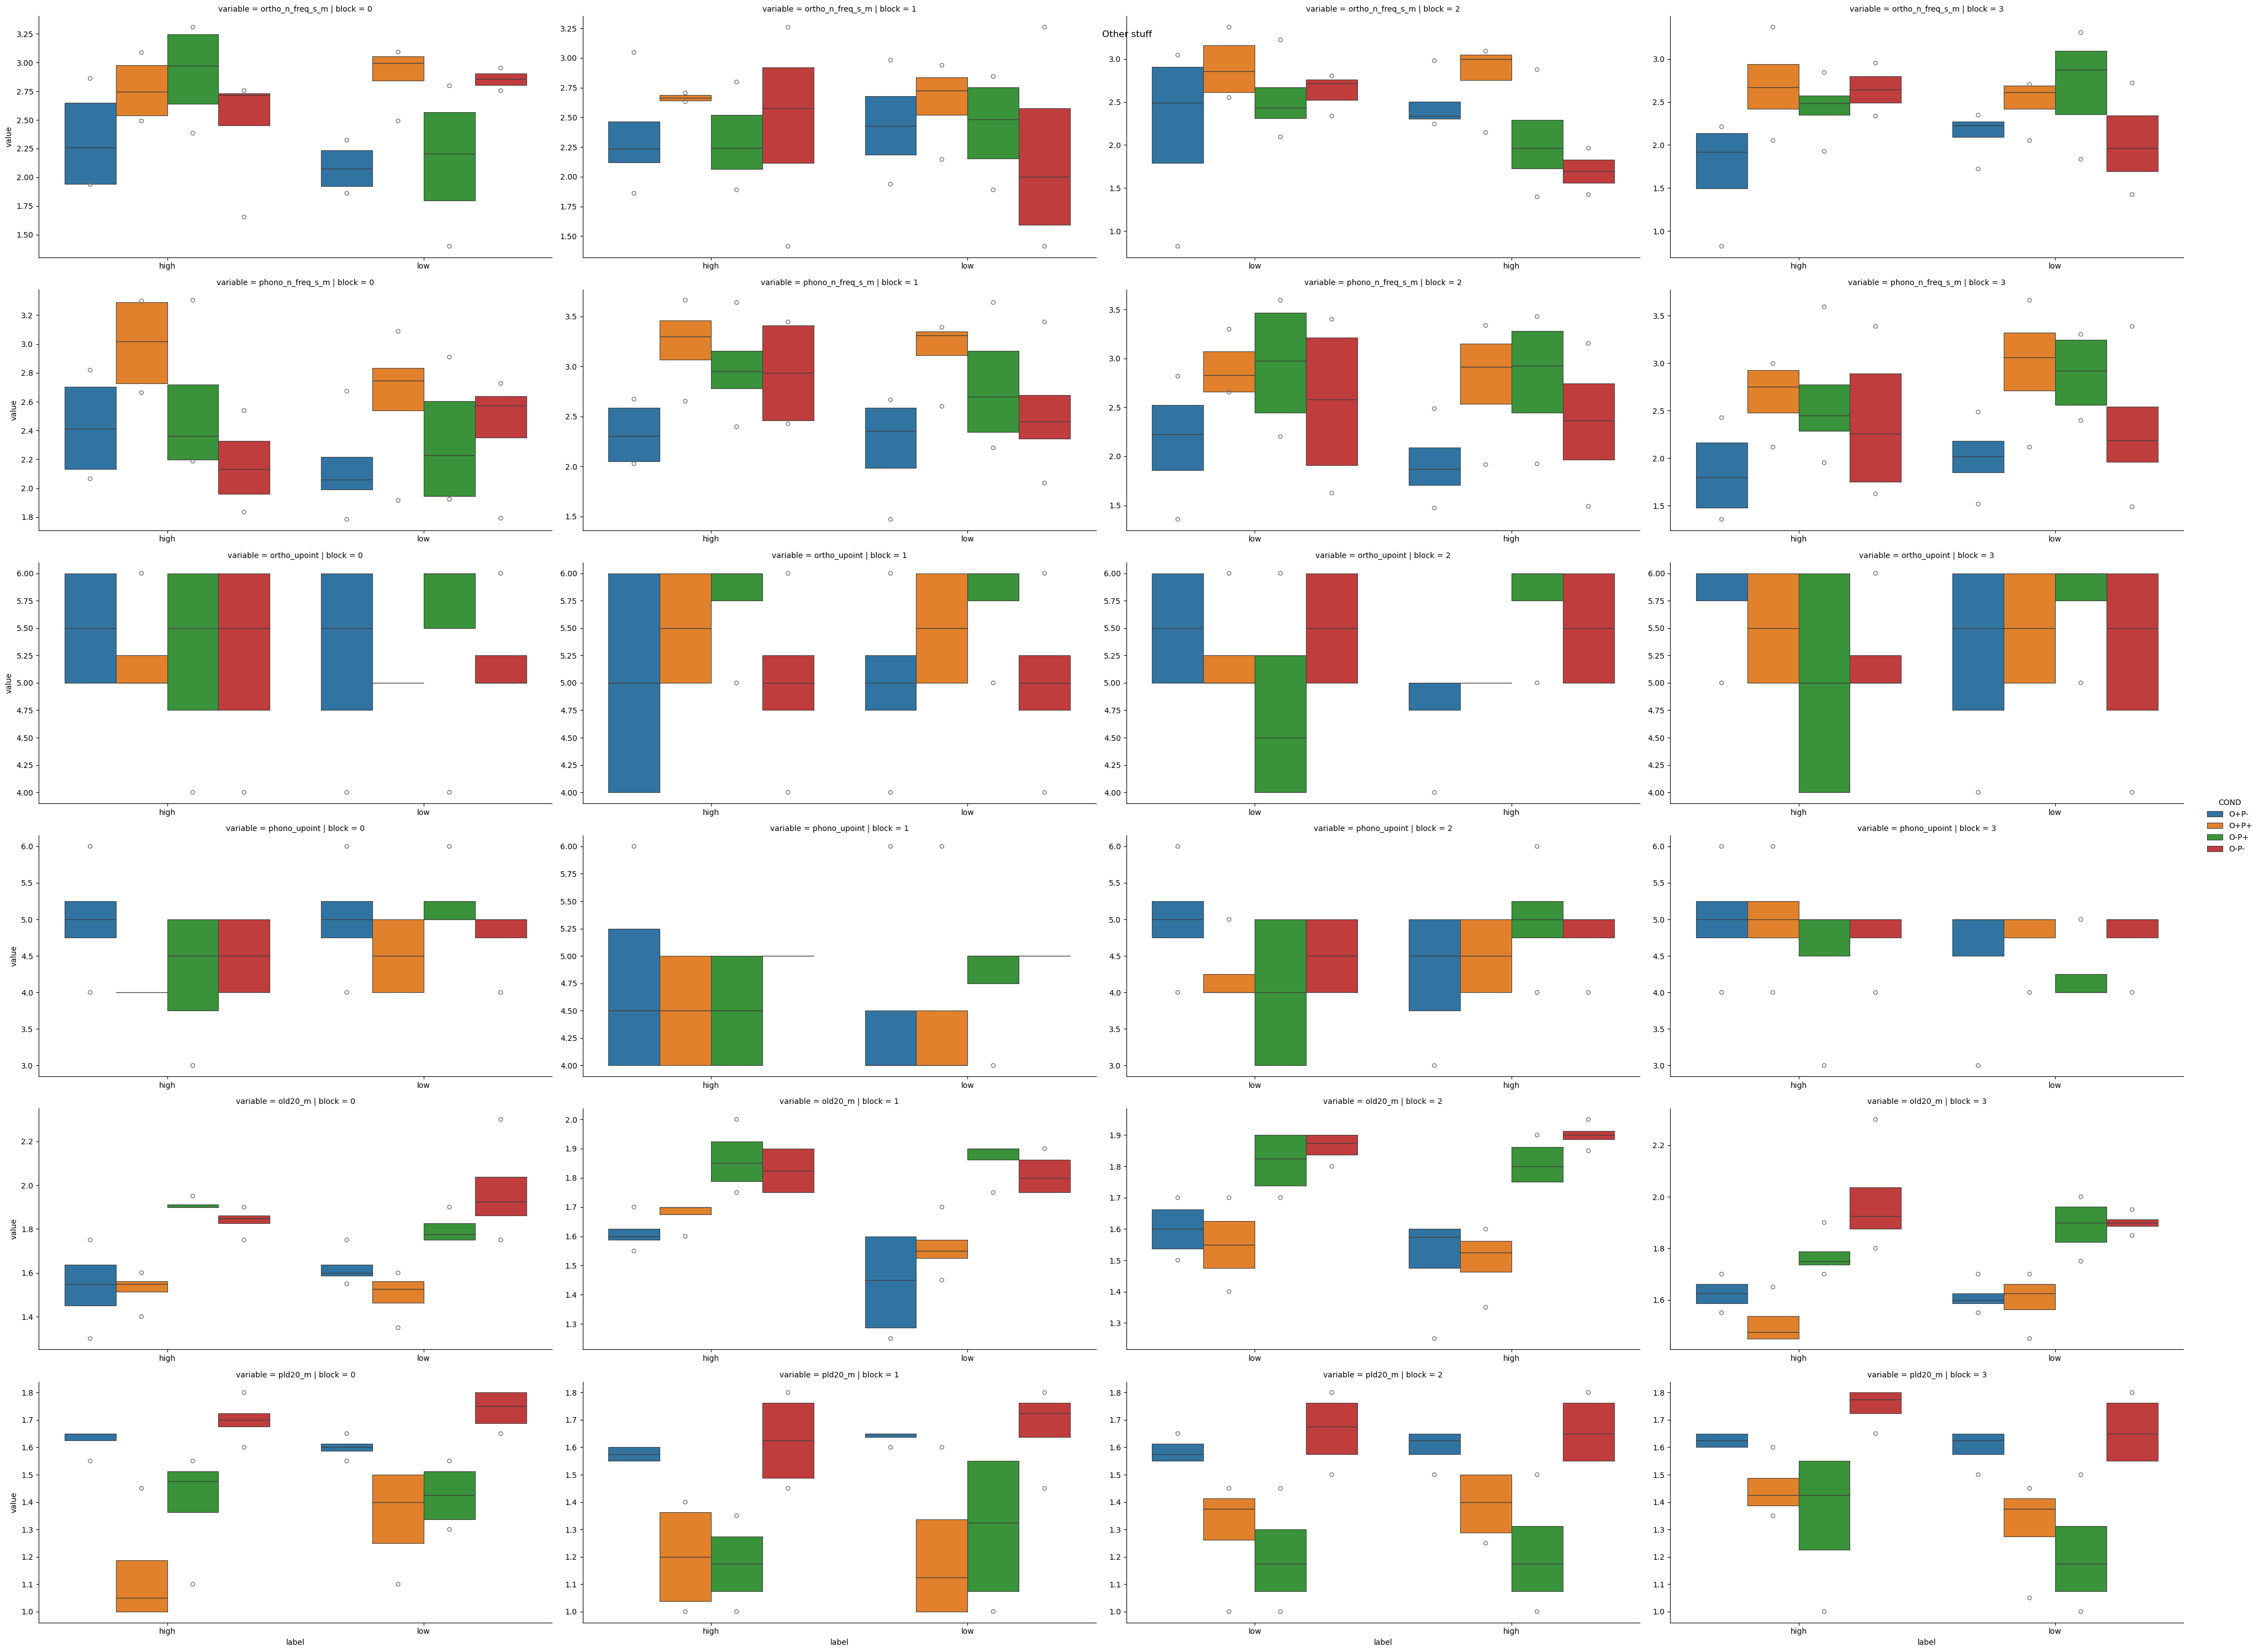

In [30]:
g = sns.catplot(data=s_melted[~s_melted.variable.isin(gen.min_variables + gen.max_variables)],
                x="label", hue="COND", y="value", row="variable", col="block",
                kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Other stuff")